
Project: Malaria-Chocó
Author: Daniela A Puentes Herrera 
Date: 28 November 2025

Description:
------------
This script provides two main functions to manage Python dependencies
for the Malaria-Chocó analysis environment.

1. load_or_install(packages):
   Attempts to import each requested package. If a package is missing,
   the function installs it using pip and then imports it again.

2. setup_environment():
   Defines all required libraries, installs missing ones, and returns
   a dictionary containing the imported modules for convenient access.

Notes:
------
- Built-in packages (glob, math, re) are not installed.
- Matplotlib is configured to use the "Agg" backend for environments
  without display systems (e.g., servers or clusters).


In [16]:
import importlib, subprocess, sys

def load_or_install(pkgs):
    for p in pkgs:
        try: importlib.import_module(p)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])

def setup_environment():
    pkgs = ["glob2","imageio","matplotlib","numpy","pandas","rasterio"]
    load_or_install(pkgs)

    import glob, math, re, tempfile
    from pathlib import Path
    import imageio, matplotlib
    matplotlib.use("Agg")
    import matplotlib.pyplot as plt
    import numpy as np, pandas as pd, rasterio
    from matplotlib.colors import BoundaryNorm, ListedColormap

    return locals()

env = setup_environment()
import geopandas as gpd
import os 


# 1. Cargar datos 
ruta = "/Users/mac/Desktop/PROJECTS/Proyecto-Cuantitativa/Malaria-Choco-Proj/datos/choco_data_V2.csv"
datos = env["pd"].read_csv(ruta)

print(datos.info())
print(datos.head())

# 2. Filter by species (Falciparum) and remove rows with missing values
falciparum = datos[datos["MALARIA"] == "MALARIA VIVAX"]

falciparum["DATE2"] = env["pd"].to_datetime(falciparum["DATE2"], format="%Y-%m")

print(falciparum.info())
print(falciparum.head())


# Columns to interpolate
cols = ["MUN_ELV_MAX", "MUN_ELV_MEAN", "MUN_T_MEAN_MAX", "MUN_T_MEAN_MIN", "MUN_T_MEAN_MEAN", "PREC_CUM_MONTH", "mean_evi", "mean_evi_interp"]

# Group by municipality, sort by date, interpolate linearly
falciparum = falciparum.sort_values(["COD_MUN", "DATE2"])

# Interpolate per municipality preserving original index
falciparum[cols] = (
    falciparum.groupby("COD_MUN")[cols]
              .transform(lambda g: g.interpolate("linear"))
)

print(falciparum.info())
print(falciparum.head())


# Ahora falciparum tiene los valores interpolados linealmente para las columnas especificadas.
# Puedes guardar el DataFrame resultante si es necesario
output_ruta = "/Users/mac/Desktop/PROJECTS/Proyecto-Cuantitativa/Malaria-Choco-Proj/datos/choco_data_vivax_interpolated.csv"
falciparum.to_csv(output_ruta, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FEC_ANO          10800 non-null  int64  
 1   FEC_MES          10800 non-null  int64  
 2   COD_MUN          10800 non-null  int64  
 3   MALARIA          10800 non-null  object 
 4   DATE2            10800 non-null  object 
 5   CASES            10800 non-null  int64  
 6   URB_ELV_MEAN     10800 non-null  int64  
 7   MUN_ELV_MAX      10800 non-null  int64  
 8   MUN_ELV_MEAN     10800 non-null  float64
 9   MUN_T_MEAN_MAX   10758 non-null  float64
 10  MUN_T_MEAN_MIN   10758 non-null  float64
 11  MUN_T_MEAN_MEAN  10758 non-null  float64
 12  PREC_CUM_MONTH   10800 non-null  float64
 13  mean_evi         10418 non-null  float64
 14  mean_evi_interp  10798 non-null  float64
dtypes: float64(7), int64(6), object(2)
memory usage: 1.2+ MB
None
   FEC_ANO  FEC_MES  COD_MUN             M

/var/folders/x2/dpdkmh79163bwtnbcbf5yb0m0000gn/T/ipykernel_6984/1107101251.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falciparum["DATE2"] = env["pd"].to_datetime(falciparum["DATE2"], format="%Y-%m")


In [17]:
import importlib, subprocess, sys

def load_or_install(pkgs):
    for p in pkgs:
        try: importlib.import_module(p)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])

def setup_environment():
    pkgs = ["glob2","imageio","matplotlib","numpy","pandas","rasterio"]
    load_or_install(pkgs)

    import glob, math, re, tempfile
    from pathlib import Path
    import imageio, matplotlib
    matplotlib.use("Agg")
    import matplotlib.pyplot as plt
    import numpy as np, pandas as pd, rasterio
    from matplotlib.colors import BoundaryNorm, ListedColormap

    return locals()

env = setup_environment()
import geopandas as gpd
import os 

import matplotlib.pyplot as plt


In [18]:
# Verificamos que los datos se hayan guardado correctamente
datos = env["pd"].read_csv("/Users/mac/Desktop/PROJECTS/Proyecto-Cuantitativa/Malaria-Choco-Proj/datos/choco_data_vivax_interpolated.csv")

print(datos.info())
print(datos.head())

# Cargamos la data espacial de los municipios
shapefile_path = "/Users/mac/Desktop/PROJECTS/Proyecto-Cuantitativa/Malaria-Choco-Proj/Choco-shape/choco_mun.shp"
municipios = gpd.read_file(shapefile_path)


# Ajustar tipos de datos para la fusión
municipios["COD_MUN"] = municipios["COD_MUN"].astype(int)
datos["COD_MUN"] = datos["COD_MUN"].astype(int)

# Unir los datos tabulares con los datos espaciales
gdf = municipios.merge(datos, on="COD_MUN", how="left")


print(gdf.info())
print(gdf.head())


# Vamos a graficar una fecha en especifico 
sel = gdf[gdf["DATE2"] == "2018-07-01"]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FEC_ANO          5400 non-null   int64  
 1   FEC_MES          5400 non-null   int64  
 2   COD_MUN          5400 non-null   int64  
 3   MALARIA          5400 non-null   object 
 4   DATE2            5400 non-null   object 
 5   CASES            5400 non-null   int64  
 6   URB_ELV_MEAN     5400 non-null   int64  
 7   MUN_ELV_MAX      5400 non-null   int64  
 8   MUN_ELV_MEAN     5400 non-null   float64
 9   MUN_T_MEAN_MAX   5400 non-null   float64
 10  MUN_T_MEAN_MIN   5400 non-null   float64
 11  MUN_T_MEAN_MEAN  5400 non-null   float64
 12  PREC_CUM_MONTH   5400 non-null   float64
 13  mean_evi         5399 non-null   float64
 14  mean_evi_interp  5399 non-null   float64
dtypes: float64(7), int64(6), object(2)
memory usage: 632.9+ KB
None
   FEC_ANO  FEC_MES  COD_MUN        MALARI

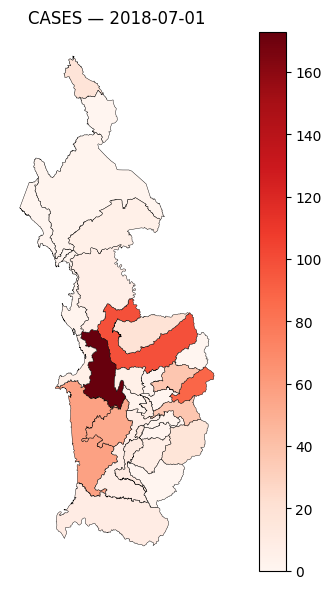

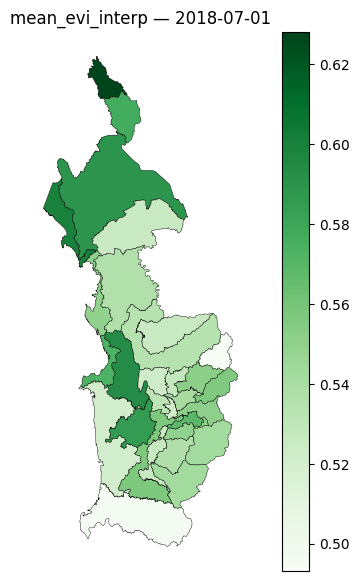

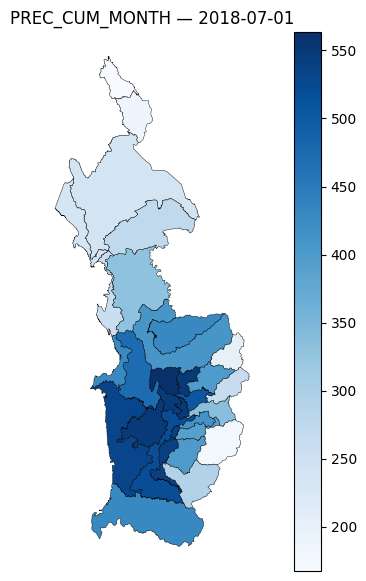

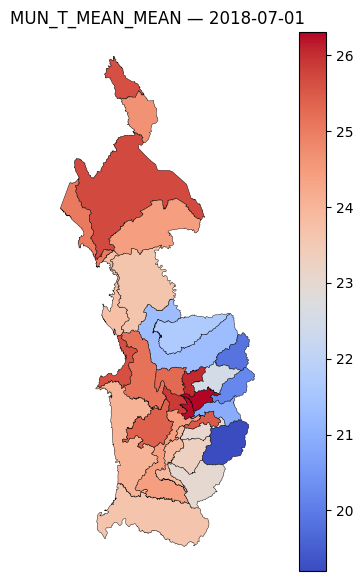

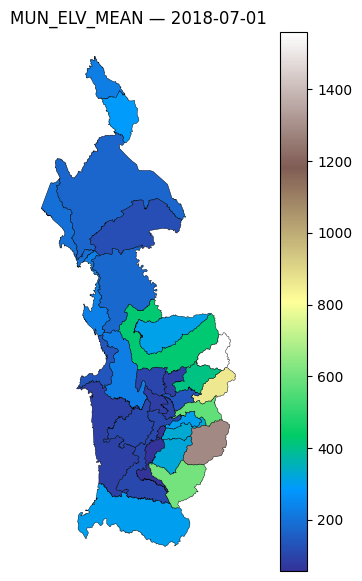

In [19]:
%matplotlib inline
def plot_var(gdf_sel, var, cmap="viridis"):
    fig, ax = plt.subplots(figsize=(9, 7))
    gdf_sel.plot(
        column=var,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.3,
        legend=True,
        ax=ax
    )
    ax.set_title(f"{var} — {gdf_sel['DATE2'].iloc[0]}")
    ax.axis("off")
    plt.show()


plot_var(sel, "CASES", cmap="Reds")
plot_var(sel, "mean_evi_interp", cmap="Greens")
plot_var(sel, "PREC_CUM_MONTH", cmap="Blues")
plot_var(sel, "MUN_T_MEAN_MEAN", cmap="coolwarm")   
plot_var(sel, "MUN_ELV_MEAN", cmap="terrain")

In [ ]:
def timelapse_variable(gdf, var, cmap, out_gif):
    import imageio.v2 as imageio
    import matplotlib.pyplot as plt
    import tempfile

    # Temporary folder for frames
    temp_dir = tempfile.mkdtemp()
    frames = []

    # Fixed figure size
    fig_w, fig_h = 8, 6  

    # Fixed legend range so colors don't jump
    vmin = gdf[var].min()
    vmax = gdf[var].max()

    # Loop through dates in order
    for date in sorted(gdf["DATE2"].unique()):
        gdf_sel = gdf[gdf["DATE2"] == date]

        fig, ax = plt.subplots(figsize=(fig_w, fig_h))

        # Plot map
        gdf_sel.plot(
            column=var,
            cmap=cmap,
            edgecolor="black",
            linewidth=0.2,
            legend=True,
            vmin=vmin,
            vmax=vmax,
            ax=ax
        )

        # ------------ MODIFY TITLE HERE ------------
        ax.set_title(f"Malaria cases — {date}", fontsize=16, fontweight="bold")
        # -------------------------------------------

        ax.axis("off")

        plt.tight_layout(pad=0)

        # Save frame
        frame_path = f"{temp_dir}/{date}.png"
        plt.savefig(frame_path, dpi=120, bbox_inches="tight")
        plt.close()

        # Add to GIF frames
        frames.append(imageio.imread(frame_path))

    # Create GIF
    imageio.mimsave(out_gif, frames, duration=1)
    print(f"Timelapse saved → {out_gif}")

In [ ]:
OUT_DIR = "/Users/mac/Desktop/PROJECTS/Proyecto-Cuantitativa/Malaria-Choco-Proj/out_gif"
gif_path = f"{OUT_DIR}/cases_timelapse_vivax.gif"
timelapse_variable(gdf, var="CASES", cmap="Reds", out_gif=gif_path)

Timelapse saved → /Users/mac/Desktop/PROJECTS/Proyecto-Cuantitativa/Malaria-Choco-Proj/out_gif/cases_timelapse_vivax.gif
